<a href="https://colab.research.google.com/github/MuhammadFakharAbbas512/Python_Projects/blob/main/ConvLSTM_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 # instaling PAFY
%pip install pafy youtube-dl moviepy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.1 MB/s eta 0:00:00


##Importing Libraries and Tensorflow Layers


In [2]:
#imprting libraries
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline
#importing Train-Test split
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model




  if event.key is 'enter':



In [3]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

#Downloading Dataset

In [4]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
!unrar x UCF101.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c05.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c06.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c01.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c02.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c03.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c04.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c05.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c06.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGu

In [5]:
all_class = os.listdir('UCF-101')
print(all_class)

['HandstandPushups', 'PizzaTossing', 'SoccerPenalty', 'FrontCrawl', 'Nunchucks', 'SalsaSpin', 'GolfSwing', 'Shotput', 'BodyWeightSquats', 'FieldHockeyPenalty', 'SkateBoarding', 'HorseRiding', 'VolleyballSpiking', 'BasketballDunk', 'Lunges', 'Diving', 'JumpingJack', 'BaseballPitch', 'BalanceBeam', 'RockClimbingIndoor', 'Skijet', 'Archery', 'SumoWrestling', 'CleanAndJerk', 'IceDancing', 'ApplyLipstick', 'PlayingPiano', 'Knitting', 'WritingOnBoard', 'PlayingDhol', 'HighJump', 'BoxingSpeedBag', 'BenchPress', 'Kayaking', 'BabyCrawling', 'PullUps', 'Fencing', 'PlayingCello', 'StillRings', 'Skiing', 'BreastStroke', 'SkyDiving', 'Haircut', 'MilitaryParade', 'Biking', 'MoppingFloor', 'WalkingWithDog', 'HulaHoop', 'Typing', 'CuttingInKitchen', 'PlayingDaf', 'Drumming', 'TableTennisShot', 'PlayingViolin', 'PlayingTabla', 'Surfing', 'JumpRope', 'BlowingCandles', 'ThrowDiscus', 'PushUps', 'BandMarching', 'TaiChi', 'ParallelBars', 'FrisbeeCatch', 'TrampolineJumping', 'PoleVault', 'Rafting', 'Playing

#Displaying Random Video Frames from UCF-101
This code generates a grid of 20 randomly selected video frames from the UCF-101 dataset, each with the corresponding class label overlaid. It uses OpenCV to read and process the video frames and Matplotlib to display the grid.

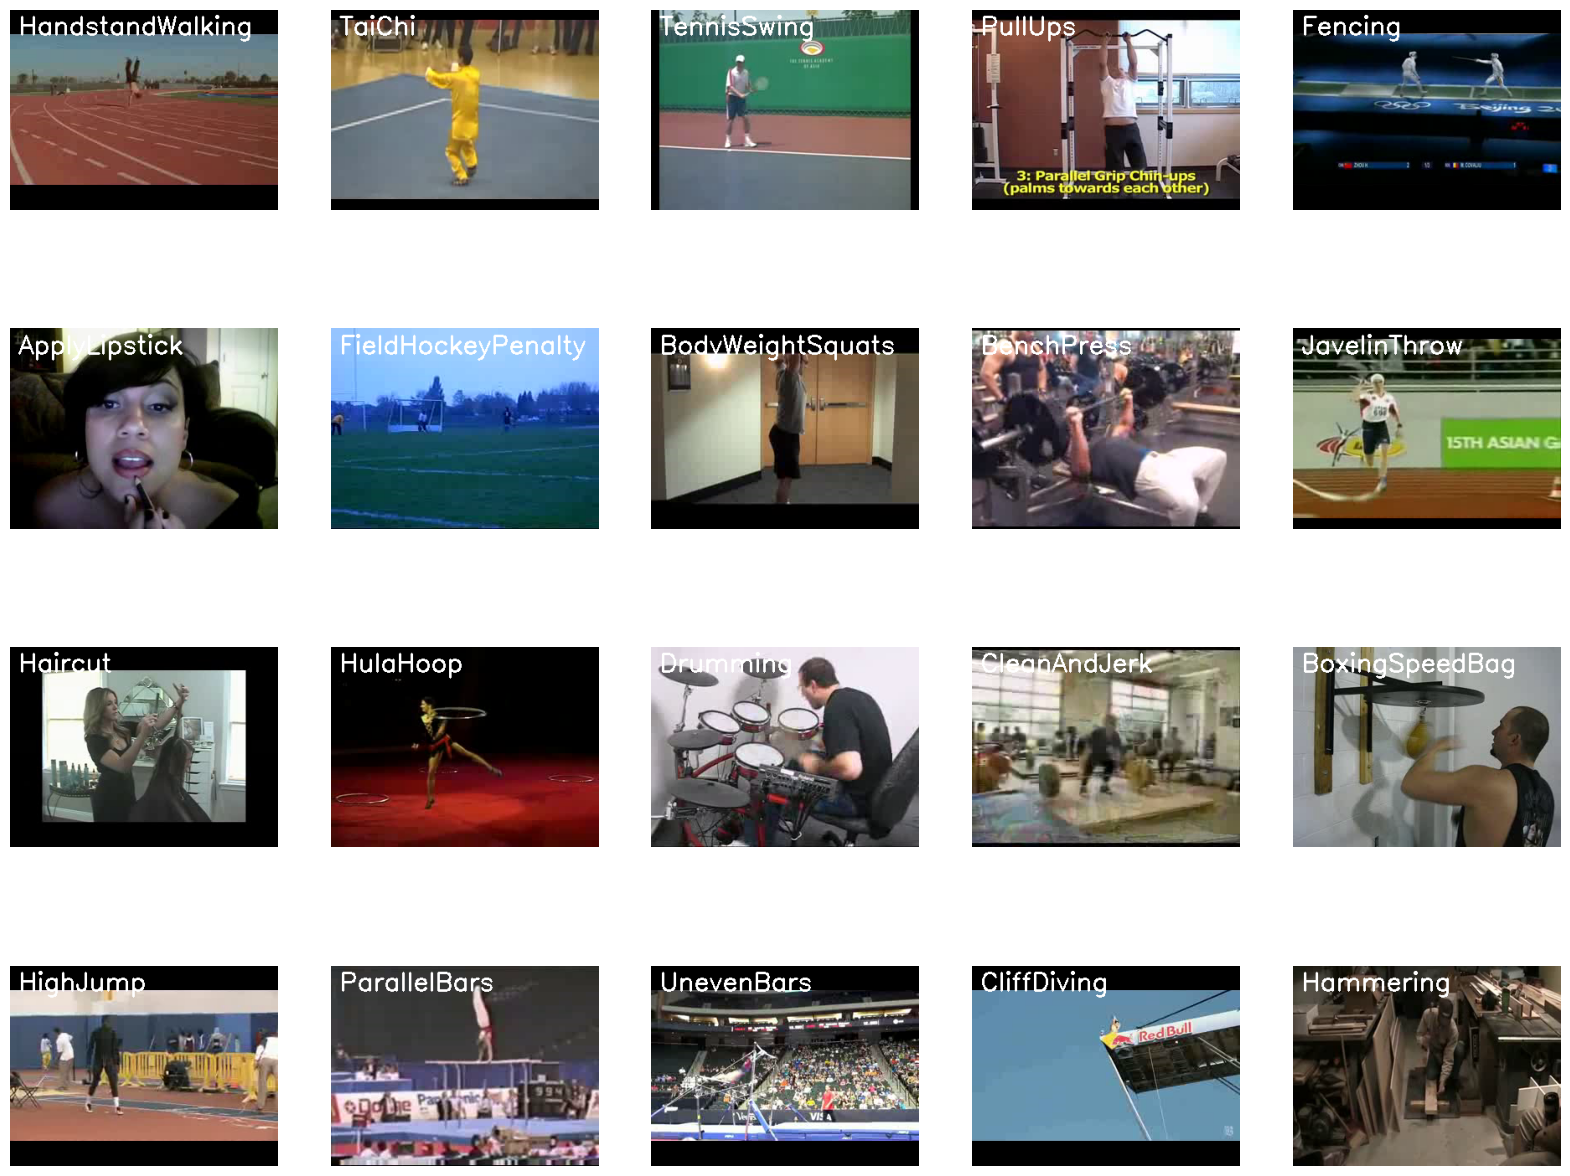

In [6]:
plt.figure(figsize = (20,20))

random_range = random.sample(range(len(all_class)),20)

for counter, random_index in enumerate(random_range,1):
  selected_class_Name= all_class[random_index]
  video_files_name_list = os.listdir(f'UCF-101/{selected_class_Name}')
  selected_video_file_name = random.choice(video_files_name_list)
  video_reader = cv2.VideoCapture(f'UCF-101/{selected_class_Name}/{selected_video_file_name}')
  _, bgr_frame = video_reader.read()
  video_reader.release
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  cv2.putText(rgb_frame, selected_class_Name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255), 2)
  plt.subplot(5,5,counter)
  plt.imshow(rgb_frame)
  plt.axis('off')


#Preprocessing the data

In [7]:
IMAGE_HEIGHT, IMAGE_LENGHT= 64,64

Sequence_Length = 20
Dataset_Directory = 'UCF-101'
#Classes_List=all_class
Classes_List=['WalkingWithDog','Biking','Bowling','Diving','SoccerPenalty']

In [8]:
print(Classes_List)

['WalkingWithDog', 'Biking', 'Bowling', 'Diving', 'SoccerPenalty']


#Creating a function to Extract rezise and normalize frames


In [9]:
def frames_extraction(video_path):
    '''
    This function will extract frames from a video and return the path to the frame
    '''
    # Empty List declared to store video frames
    frames_list = []
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)
    #get total number of frames in video
    video_frame_count= int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #get the fps
    #video_fps= int(video_reader.get(cv2.CAP_PROP_FPS))
    #calculate the intervel after which frame will be added to list
    skip_frames_window = max(int(video_frame_count/Sequence_Length), 1)
    # iterate through the video frames
    for frame_counter in range(Sequence_Length):
      #set current frame position of video
      video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
      #reading the frame from video
      success, frame = video_reader.read()
      #Check if video frame is not read and break loop
      if not success:
          break
      # resize the frame to fixed hieght and width.
      resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_LENGHT))
      #normalize the frame between 0 to 1 by dividing by 255
      normalized_frame=resized_frame/255
      #Append the frames to list
      frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

#Create a function for dataset collection

In [10]:
def create_dataset():
  features=[]
  labels=[]
  video_file_paths=[]

  for class_index, class_name in enumerate(Classes_List):
    print(f'Extracting Data of Class: {class_name}')
    files_list=os.listdir(os.path.join(Dataset_Directory, class_name))
    for file_name in files_list:
      video_file_path=os.path.join(Dataset_Directory, class_name, file_name)
      frames=frames_extraction(video_file_path)
      if len(frames)==Sequence_Length:
        features.append(frames)
        labels.append(class_index)
        video_file_paths.append(video_file_path)

  features=np.array(features)
  labels=np.array(labels)

  return features, labels, video_file_paths

#CREATE DATASET

In [11]:
features, labels, video_file_paths=create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: Biking
Extracting Data of Class: Bowling
Extracting Data of Class: Diving
Extracting Data of Class: SoccerPenalty


In [12]:
#one hot encoding
one_hot_encoded_labels=to_categorical(labels)

#Train Test split

In [13]:
X_train, X_test , y_train, y_test = train_test_split(features,one_hot_encoded_labels, test_size=0.25, random_state=seed_constant,shuffle=True)

#Create ConvLSTM model

In [18]:
def create_convlstm_model():
    model = Sequential()
    model.add(ConvLSTM2D(filters=4,kernel_size=(3,3), activation='tanh',data_format='channels_last', recurrent_dropout=0.2, return_sequences=True, input_shape=(Sequence_Length, IMAGE_HEIGHT, IMAGE_LENGHT, 3)))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same',data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(ConvLSTM2D(filters=8,kernel_size=(3,3), activation='tanh',data_format='channels_last', recurrent_dropout=0.2, return_sequences=True, ))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same',data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(ConvLSTM2D(filters=14,kernel_size=(3,3), activation='tanh',data_format='channels_last', recurrent_dropout=0.2, return_sequences=True, ))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same',data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    model.add(ConvLSTM2D(filters=16,kernel_size=(3,3), activation='tanh',data_format='channels_last', recurrent_dropout=0.2, return_sequences=True, ))
    model.add(MaxPooling3D(pool_size=(1,2,2), padding='same',data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    model.add(Flatten())
    model.add(Dense(len(Classes_List), activation='softmax'))
    model.summary()
    return model


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_8 (ConvLSTM2D)           │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_8 (TimeDistributed) │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_9 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_9 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_10 (ConvLSTM2D)          │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_8 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 20, 7, 7, 14)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_11 (ConvLSTM2D)          │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_9 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │          14,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,405 (185.18 KB)

 Trainable params: 47,405 (185.18 KB)

 Non-trainable params: 0 (0.00 B)

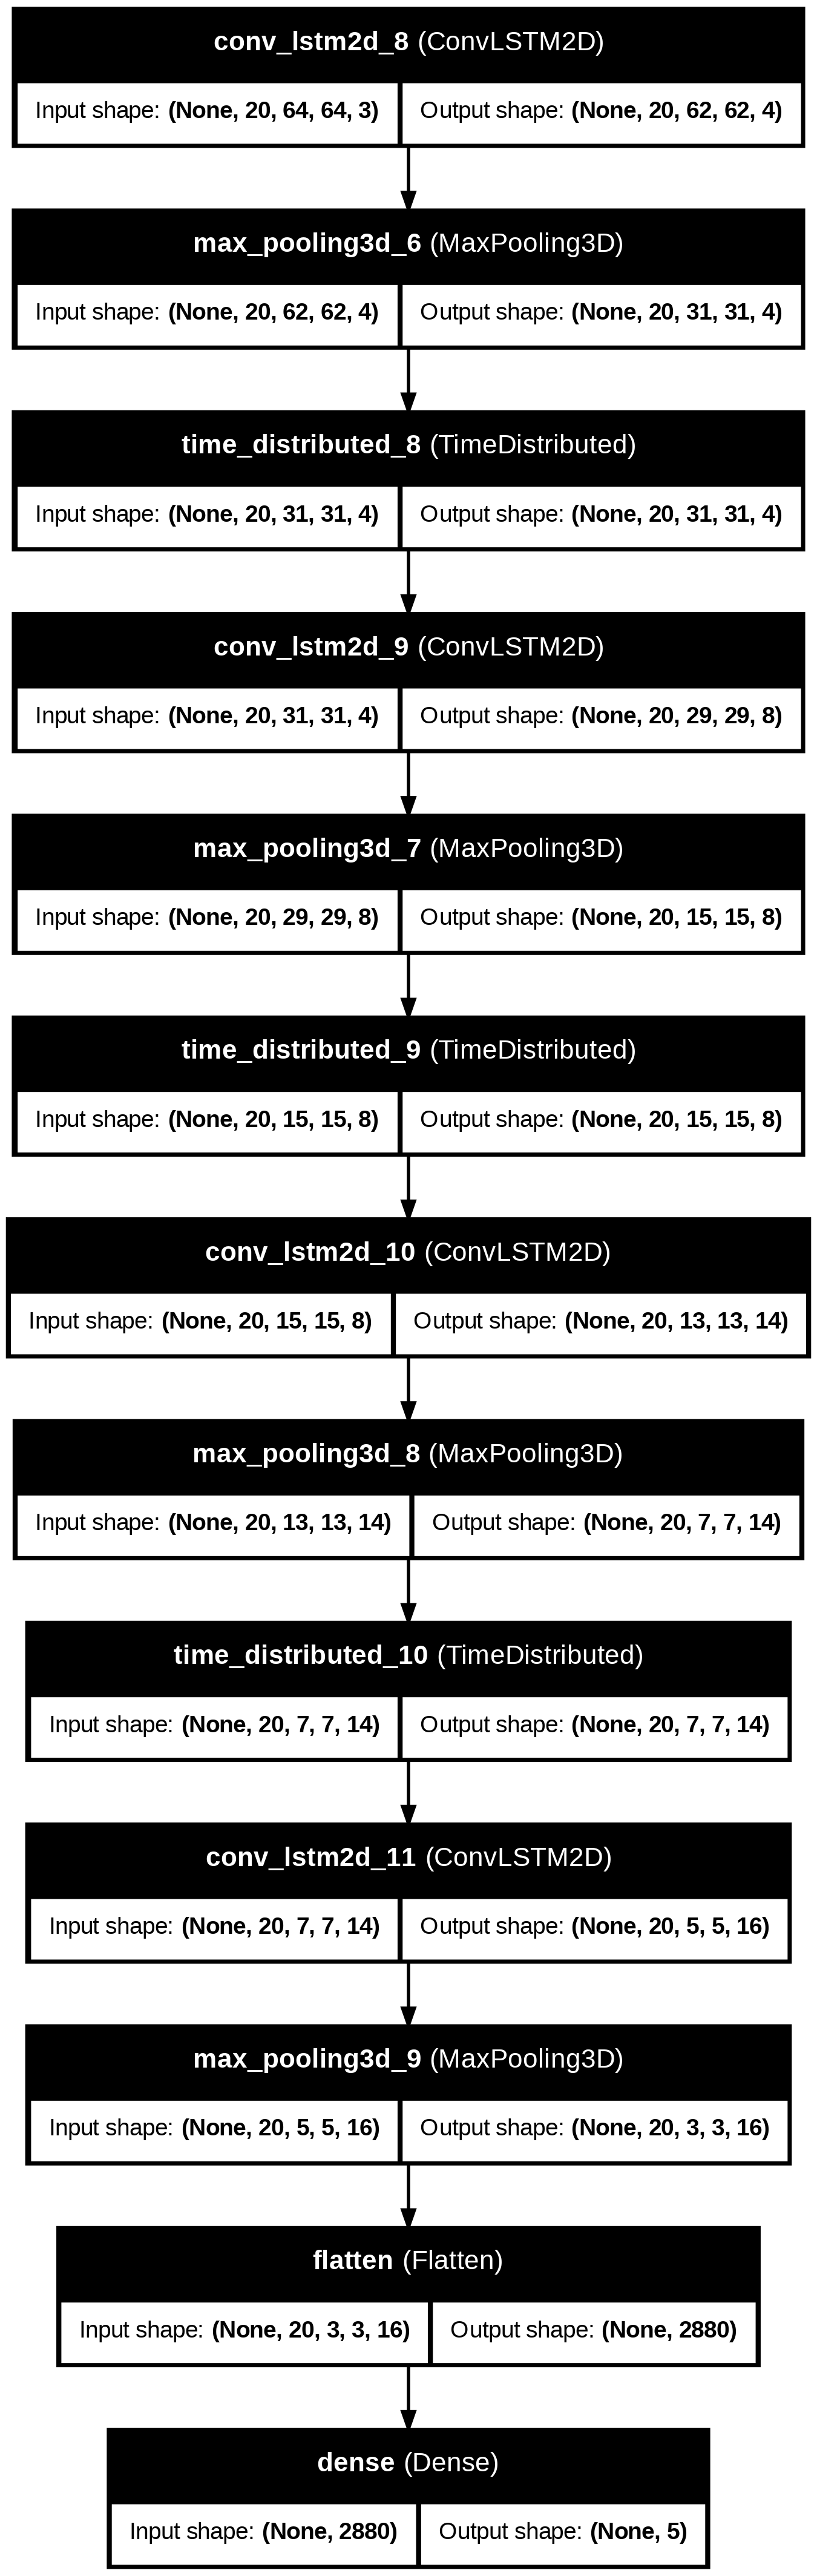

In [19]:
plot_model(create_convlstm_model(), to_file='convlstm_model_structure_plot.png', show_shapes=True, show_layer_names=True)

#Compile and train the model

In [20]:
convlstm_model=create_convlstm_model()
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10,mode='min,restore_best_weights=True')
convlstm_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
convlstm_model_training_history=convlstm_model.fit(X_train,y_train,epochs=50,batch_size=4,shuffle=True,validation_split=0.2,callbacks=[early_stopping_callback])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_12 (ConvLSTM2D)          │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_10 (MaxPooling3D)      │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 20, 31, 31, 4)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_13 (ConvLSTM2D)          │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_11 (MaxPooling3D)      │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 20, 15, 15, 8)       │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_14 (ConvLSTM2D)          │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_12 (MaxPooling3D)      │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 20, 7, 7, 14)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_15 (ConvLSTM2D)          │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_13 (MaxPooling3D)      │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │          14,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,405 (185.18 KB)

 Trainable params: 47,405 (185.18 KB)

 Non-trainable params: 0 (0.00 B)

  early_stopping_callback=EarlyStopping(monitor='val_loss',patience=10,mode='min,restore_best_weights=True')



Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 208s 2s/step - accuracy: 0.2862 - loss: 1.5460 - val_accuracy: 0.5143 - val_loss: 1.2006
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.6159 - loss: 1.0014 - val_accuracy: 0.6857 - val_loss: 0.7941
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.7315 - loss: 0.7321 - val_accuracy: 0.7714 - val_loss: 0.5755
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.7804 - loss: 0.5869 - val_accuracy: 0.7714 - val_loss: 0.5507
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.8199 - loss: 0.4919 - val_accuracy: 0.7238 - val_loss: 0.5196
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.8353 - loss: 0.4282 - val_accuracy: 0.6190 - val_loss: 0.7831
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.8372 - loss: 0.4582 - val_accuracy: 0.8190 - val_loss: 0.4851
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.8586 - loss: 0.3790 - val_accu

In [21]:
!pip install seaborn
import seaborn as sns

#Plot traing and validation accuracy and loss

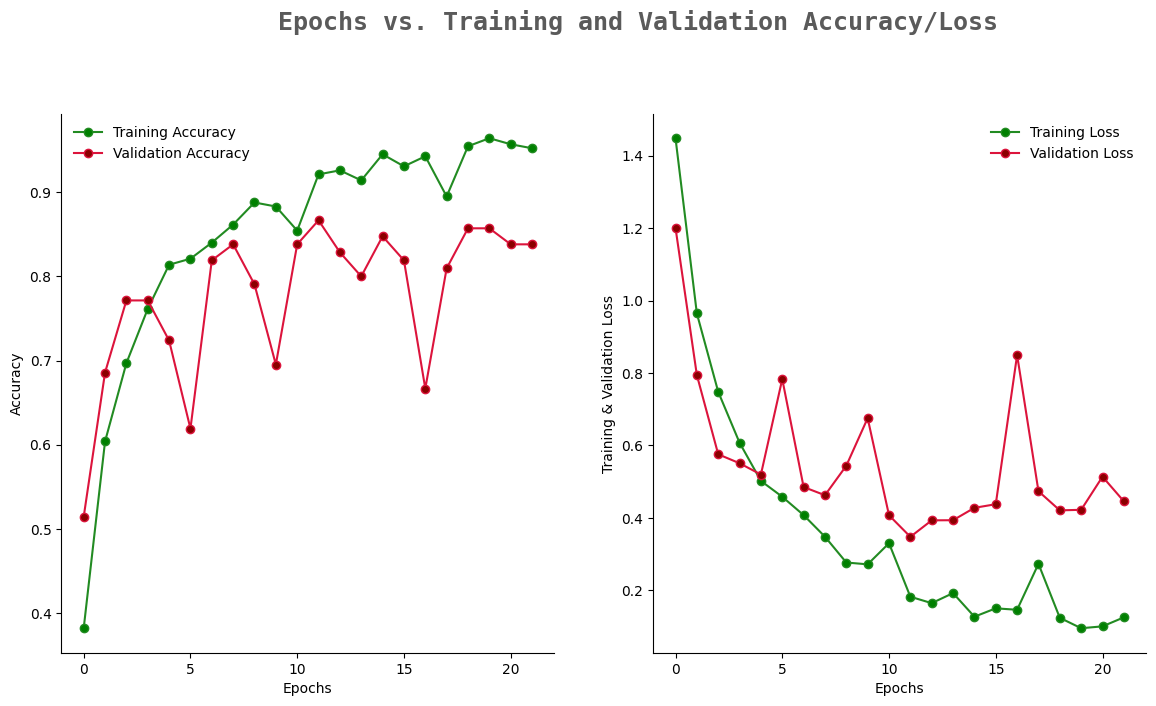

In [22]:
epochs = [i for i in range(len(convlstm_model_training_history.history['accuracy']))] # Create epochs list based on length of training history
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_green = ["#00FF00", "#32CD32", '#008000', '#228B22', '#006400']
colors_red = ["#FF0000", "#B22222", '#8B0000', '#DC143C', '#FF6347']
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = convlstm_model_training_history.history['accuracy']
train_loss = convlstm_model_training_history.history['loss']
val_acc = convlstm_model_training_history.history['val_accuracy']
val_loss =convlstm_model_training_history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [23]:
model_evalution_history=convlstm_model.evaluate(X_test,y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.8433 - loss: 0.4246


In [24]:
# Saving the trained model
model_save_path = 'convlstm_model.h5'
convlstm_model.save(model_save_path)


In [28]:
# Save only the weights
convlstm_model.save_weights('.weights.h5')


In [ ]:
### Loading the saved model
from tensorflow.keras.models import load_model
convlstm_model_loaded = load_model('convlstm_model.h5')


In [ ]:
def frames_extraction(video_path, sequence_length=10):
    '''
    This function will extract frames from a video and return exactly `sequence_length` frames.
    '''
    # Empty List declared to store video frames
    frames_list = []
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)
    # Get total number of frames in the video
    video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    # Calculate the interval after which the frame will be added to the list
    skip_frames_window = max(int(video_frame_count / sequence_length), 1)

    # Extract frames
    for frame_counter in range(sequence_length):
        # Set current frame position in video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        # Read the frame
        success, frame = video_reader.read()
        # Check if frame is successfully read
        if not success:
            break
        # Resize frame to fixed dimensions
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_LENGHT))
        # Normalize the frame (0-1 range)
        normalized_frame = resized_frame / 255.0
        frames_list.append(normalized_frame)

    video_reader.release()

    # If the number of frames is less than required, pad the frames list with the last frame
    while len(frames_list) < sequence_length:
        frames_list.append(frames_list[-1])  # Repeat the last frame

    return frames_list
# Example usage: Predict and display frames for a single video
def predict_and_display(input_video_path, model):
    # Extract frames from the video (10 frames as input)
    input_frames = frames_extraction(input_video_path, sequence_length=10)

    # Ensure the frames are in the shape required by the model (e.g., (1, 10, 64, 64, 3))
    input_frames = np.array(input_frames).reshape(1, 10, IMAGE_HEIGHT, IMAGE_LENGHT, 3)

    # Make predictions (model generates 5 predicted frames)
    predicted_frames = model.predict(input_frames)

    # Display input frames and predicted frames
    fig, axes = plt.subplots(2, 10, figsize=(20, 5))

    # Display input frames (10 frames)
    for i in range(10):
        axes[0, i].imshow(input_frames[0][i])  # Display each of the input frames
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Input {i + 1}')

    # Display predicted frames (5 frames)
    for i in range(5):
        axes[1, i].imshow(predicted_frames[0][i])  # Display each of the predicted frames
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Predicted {i + 1}')

    plt.show()
input_video_path = '/content/UCF-101/Biking/v_Biking_g02_c01.avi'  # Replace with your actual video path
predict_and_display(input_video_path, convlstm_model)
